In [ ]:
# Install TA-Lib in Google Colab (GPU environment)
# Make sure to select GPU runtime: Runtime > Change runtime type > Hardware accelerator > GPU

# First, check if GPU is available
import torch
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")

# Install dependencies and build TA-Lib from source
!sudo apt-get update
!sudo apt-get install -y build-essential wget pkg-config

# Download and compile TA-Lib from source
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzf ta-lib-0.4.0-src.tar.gz
%cd ta-lib/
!./configure --prefix=/usr
!make -j$(nproc)
!sudo make install

# Add library to path and install Python wrapper
!sudo ldconfig
%cd /content

# First, let's check the Python version to find a compatible wheel
import sys
print(f"Python version: {sys.version}")
python_version = f"cp{sys.version_info.major}{sys.version_info.minor}"
print(f"Python tag: {python_version}")

# Try using conda installation (often more reliable)
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install -c conda-forge ta-lib -y

# Try downloading a pre-built wheel first (this often works better in Colab)
# Select the wheel based on your Python version - this one is for Python 3.10
# !pip install --no-cache-dir https://files.pythonhosted.org/packages/25/05/3454ccb2ddad24257f2377d663b3fbf869e80e91d698dc70ac68c536fbed/TA_Lib-0.4.27-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

# If the wheel installation fails, fall back to compiling from source
# Uncomment the line below if the wheel installation fails
# !CFLAGS="-I/usr/include" LDFLAGS="-L/usr/lib" pip install --no-cache-dir TA-Lib

# Verify the installation
import talib
print(f"TA-Lib installed: {talib.__file__}")

GPU available: True
GPU device: Tesla T4
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [70.9 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,802 kB]
Get:13 http://archive.ubuntu.com/ubun

Running in Colab. Installing necessary packages...
Installations complete.
Loading data from SPX500_M15.csv...
Preprocessing raw data...
Calculating technical indicators...
Calculating ORB for SPX500 (first 15 mins)...
NaNs handled: Initial=6159, Final=0. Remaining rows: 117749
Preprocessing complete.
Splitting data at 2024-01-01...
Training data: 92443 rows (2020-01-02 07:15:00+00:00 to 2023-12-29 21:45:00+00:00)
Testing data: 25306 rows (2024-01-02 00:00:00+00:00 to 2025-02-04 23:45:00+00:00)
Setting up training environment...
Observation space shape: (60, 22)
Number of input features per step: 22
Setting up NEW TD3 model with Custom LSTM Extractor...
Model Architecture:
TD3Policy(
  (actor): Actor(
    (features_extractor): LSTMExtractor(
      (lstm): LSTM(22, 64, batch_first=True)
      (linear): Linear(in_features=64, out_features=32, bias=True)
      (relu): ReLU()
    )
    (mu): Sequential(
      (0): Linear(in_features=32, out_features=2, bias=True)
      (1): Tanh()
    )
  

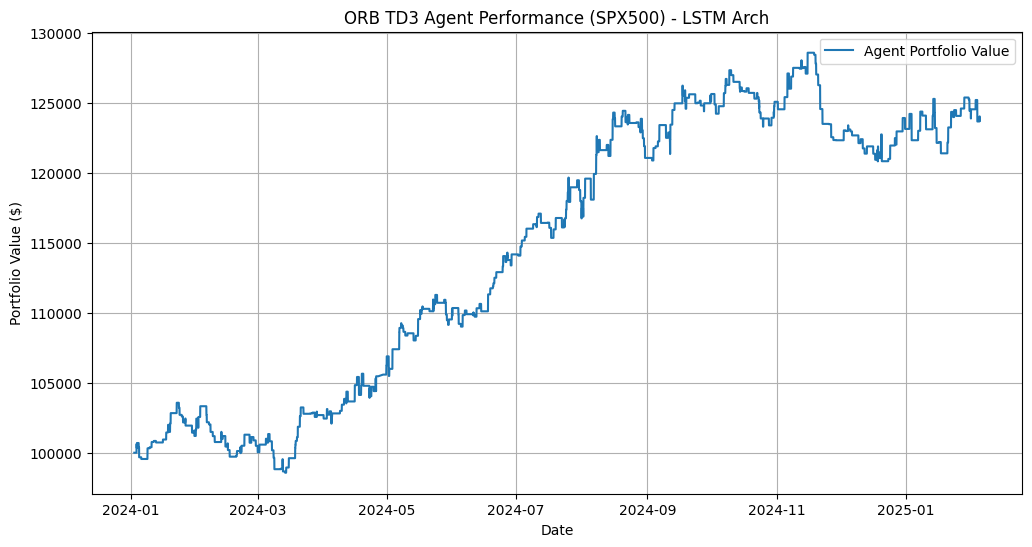

In [ ]:
###  NEW CODE>>>>>>>>>>>>>>>>>>>>>>
# Add Progress bar to training
# Config variable to automatically extend training if we specify whch model to use

# -*- coding: utf-8 -*-
"""
FinRL TD3 ORB Training & Evaluation Script
(CSV Data, ORB Multiples Action, Bias Correction, Gymnasium Env, MlpPolicy)

This script trains a TD3 agent using an MlpPolicy and custom LSTM layer to determine stop-loss
and take-profit multiples relative to the Opening Range Breakout (ORB) range.
It loads data from a local CSV file, includes forward bias correction for entry,
and uses the Gymnasium API standard.

Designed for Google Colab.
"""

# 1. Installs & Imports
# ---------------------
# Install necessary packages if running in Colab
import os
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    print("Running in Colab. Installing necessary packages...")
    # Ensure necessary system libraries for TA-Lib are present
    os.system("apt-get update && apt-get install -y -qq --no-install-recommends build-essential libta-lib-dev")
    os.system("pip install -q swig")
    os.system("pip install -q wrds")
    os.system("pip install -q pyportfolioopt")
    # Install finrl library
    os.system("pip install -q git+https://github.com/AI4Finance-Foundation/FinRL.git")
    # Install stable-baselines3 for RL algorithms
    os.system("pip install -q stable-baselines3[extra]")
    # Install TA-Lib for technical indicators
    os.system("pip install -q TA-Lib")
    # Install gymnasium (if not already installed by SB3 extra)
    os.system("pip install -q gymnasium")
    print("Installations complete.")
else:
    print("Not running in Colab. Ensure necessary packages are installed.")

import pandas as pd
import numpy as np
# Check if TA-Lib import works, provide guidance if not
try:
    import talib as ta # Use TA-Lib directly
except ImportError:
    print("*"*80)
    print("ERROR: Failed to import TA-Lib.")
    print("Please ensure the TA-Lib C library is installed correctly.")
    print("In Colab, make sure the apt-get install line in Section 1 is uncommented and run.")
    print("If running locally, follow TA-Lib installation instructions for your OS.")
    print("*"*80)
    sys.exit(1)

import matplotlib.pyplot as plt
# *** Import gymnasium instead of gym ***
import gymnasium as gym
from gymnasium import spaces
# *** End Import Change ***
from stable_baselines3 import TD3
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.monitor import Monitor # Monitor expects Gymnasium env
from stable_baselines3.common.env_checker import check_env # Useful for debugging env
import datetime
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# 2. Configuration Variables
# --------------------------
# --- Data Parameters ---
CSV_FILE_PATH = 'SPX500_M15.csv' # *** IMPORTANT: Upload this file to your Colab environment ***
TICKER_SYMBOL = 'SPX500' # Symbol representing the data in the CSV
TRAIN_SPLIT_DATE = "2024-01-01" # Date to split training and testing data
DATA_INTERVAL_MINUTES = 15

# --- ORB Parameters ---
ORB_TIMEFRAME_MINUTES = 15
MARKET_OPEN_HOUR_UTC = 14
MARKET_OPEN_MINUTE_UTC = 30
MARKET_CLOSE_HOUR_UTC = 21

# --- Environment Parameters ---
INITIAL_ACCOUNT_BALANCE = 100000
TRANSACTION_FEE_PERCENT = 0.001
STATE_LOOKBACK = 60
MAX_TRADE_DURATION_BARS = 96

# --- Action Space Parameters (SL/TP Multiples of ORB Range) ---
SL_MULT_RANGE = [0.25, 3.0] # SL is 0.5x to 2.0x the ORB range away (DEFAULT)
TP_MULT_RANGE = [0.5, 5.0] # TP is 1.0x to 4.0x the ORB range away (DEFAULT)

# --- Model Parameters ---
MODEL_ALGO = "TD3"
POLICY = "MlpPolicy" # Using default MLP policy for now
TOTAL_TIMESTEPS = 100000 # Increase for real training (e.g., 1e6)
LEARNING_RATE = 1e-4
BUFFER_SIZE = 100000
BATCH_SIZE = 100
GAMMA = 0.99
TAU = 0.005
POLICY_DELAY = 2
ACTION_NOISE_STDDEV = 0.1

# --- File Paths ---
MODEL_SUFFIX = "lstm" # Suffix for this model version (MLP, Bias Corrected)
MODEL_DIR = f"./orb_td3_models_{MODEL_SUFFIX}"
LOG_DIR = f"./orb_td3_logs_{MODEL_SUFFIX}"
OUTPUT_DIR = f"./orb_td3_results_{MODEL_SUFFIX}"
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 3. Data Loading & Preprocessing Function (from CSV)
# ----------------------------------------------------
# (This function remains the same as the previous version)
def load_and_preprocess_data_from_csv(csv_path, ticker_symbol, train_split_date):
    """Loads data from CSV, preprocesses, calculates indicators and ORB."""
    print(f"Loading data from {csv_path}...")
    try:
        df_raw = pd.read_csv(csv_path)
        if df_raw.empty: raise ValueError("CSV file is empty.")
        print("Preprocessing raw data...")
        df_raw.rename(columns={"Datetime": "datetime", "Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"}, inplace=True)
        df_raw['datetime'] = pd.to_datetime(df_raw['datetime'], utc=True, errors='coerce')
        df_raw.dropna(subset=['datetime'], inplace=True)
        df_raw.set_index('datetime', inplace=True)
        for col in ['open', 'high', 'low', 'close', 'volume']: df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce')
        df_raw.dropna(subset=['open', 'high', 'low', 'close', 'volume'], inplace=True)
        df_raw['ticker'] = ticker_symbol
        df = df_raw[["ticker", "open", "high", "low", "close", "volume"]].copy()
        df.sort_index(inplace=True)
    except FileNotFoundError: print(f"Error: CSV file not found at {csv_path}. Please upload it."); return None, None
    except Exception as e: print(f"Error loading or processing CSV: {e}"); return None, None
    print("Calculating technical indicators...")
    if len(df) < 60: print(f"Error: Insufficient data ({len(df)} rows) for calculating indicators."); return None, None
    df['sma_10'] = ta.SMA(df['close'], timeperiod=10); df['sma_30'] = ta.SMA(df['close'], timeperiod=30)
    df['rsi_14'] = ta.RSI(df['close'], timeperiod=14)
    macd, macdsignal, macdhist = ta.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9); df['macd'] = macd; df['macdsignal'] = macdsignal
    upper, middle, lower = ta.BBANDS(df['close'], timeperiod=20); df['bolu'] = upper; df['bold'] = lower
    df['atr_14'] = ta.ATR(df['high'], df['low'], df['close'], timeperiod=14)
    df['cci_14'] = ta.CCI(df['high'], df['low'], df['close'], timeperiod=14)
    df['adx_14'] = ta.ADX(df['high'], df['low'], df['close'], timeperiod=14)
    print(f"Calculating ORB for {ticker_symbol} (first {ORB_TIMEFRAME_MINUTES} mins)...")
    df['date'] = df.index.date; df['time'] = df.index.time
    orb_data = {}
    market_open_time_utc = datetime.time(MARKET_OPEN_HOUR_UTC, MARKET_OPEN_MINUTE_UTC)
    orb_end_time_utc = (datetime.datetime.combine(datetime.date.today(), market_open_time_utc) + datetime.timedelta(minutes=ORB_TIMEFRAME_MINUTES)).time()
    grouped = df.groupby(df.index.date)
    for date, group in grouped:
        orb_period_df = group[(group.index.time >= market_open_time_utc) & (group.index.time < orb_end_time_utc)]
        if not orb_period_df.empty:
            orb_high = orb_period_df['high'].max(); orb_low = orb_period_df['low'].min(); orb_range = orb_high - orb_low
            orb_data[date] = {'orb_high': orb_high, 'orb_low': orb_low, 'orb_range': orb_range}
    df['orb_high'] = df['date'].map(lambda d: orb_data.get(d, {}).get('orb_high', np.nan))
    df['orb_low'] = df['date'].map(lambda d: orb_data.get(d, {}).get('orb_low', np.nan))
    df['orb_range'] = df['date'].map(lambda d: orb_data.get(d, {}).get('orb_range', np.nan))
    df.drop(columns=['date', 'time'], inplace=True)
    initial_nans = df.isna().sum().sum()
    indicator_cols = ['sma_10', 'sma_30', 'rsi_14', 'macd', 'macdsignal', 'bolu', 'bold', 'atr_14', 'cci_14', 'adx_14']
    df[indicator_cols] = df[indicator_cols].ffill()
    df.dropna(subset=['open', 'high', 'low', 'close', 'volume', 'orb_high', 'orb_low', 'orb_range'] + indicator_cols, inplace=True)
    final_nans = df.isna().sum().sum()
    print(f"NaNs handled: Initial={initial_nans}, Final={final_nans}. Remaining rows: {len(df)}")
    if df.empty: print("Error: No data remaining after processing."); return None, None
    df.sort_index(inplace=True); print("Preprocessing complete.")
    print(f"Splitting data at {train_split_date}...")
    train_df = df[df.index < train_split_date]; test_df = df[df.index >= train_split_date]
    print(f"Training data: {len(train_df)} rows ({train_df.index.min()} to {train_df.index.max()})")
    print(f"Testing data: {len(test_df)} rows ({test_df.index.min()} to {test_df.index.max()})")
    if train_df.empty or test_df.empty: print("Error: Train or test split resulted in empty dataframe."); return None, None
    return train_df, test_df


# 4. Custom Environment Class (Using Gymnasium)
# ---------------------------------------------
# *** Inherit from gymnasium.Env ***
class ORBStockTradingEnv(gym.Env):
    """
    Custom Gymnasium environment for ORB trading strategy with SL/TP prediction
    based on ORB Range Multiples. Includes correction for forward bias.
    """
    metadata = {'render.modes': ['human']}

    def __init__(self, df, lookback_window=60, initial_balance=100000,
                 transaction_fee=0.001, max_trade_duration=96,
                 sl_mult_range=SL_MULT_RANGE, tp_mult_range=TP_MULT_RANGE,
                 orb_timeframe_minutes=ORB_TIMEFRAME_MINUTES,
                 market_open_hour_utc=MARKET_OPEN_HOUR_UTC,
                 market_open_minute_utc=MARKET_OPEN_MINUTE_UTC):

        # *** Use modern super() call ***
        super().__init__()

        self.df = df.copy()
        self.lookback_window = lookback_window
        self.initial_balance = initial_balance
        self.transaction_fee = transaction_fee
        self.max_trade_duration = max_trade_duration
        self.sl_mult_range = sl_mult_range
        self.tp_mult_range = tp_mult_range
        self.orb_timeframe_minutes = orb_timeframe_minutes
        self.market_open_time_utc = datetime.time(market_open_hour_utc, market_open_minute_utc)
        self.orb_end_time_utc = (datetime.datetime.combine(datetime.date.today(), self.market_open_time_utc) +
                                 datetime.timedelta(minutes=self.orb_timeframe_minutes)).time()
        self.feature_cols = ['open', 'high', 'low', 'close', 'volume',
                             'sma_10', 'sma_30', 'rsi_14', 'macd', 'macdsignal',
                             'bolu', 'bold', 'atr_14', 'cci_14', 'adx_14',
                             'orb_high', 'orb_low', 'orb_range']
        self.state_features = self.feature_cols + ['balance', 'position', 'entry_price', 'trade_duration']

        # --- Action Space (using gymnasium.spaces) ---
        # Raw action output from TD3 actor is typically tanh (-1, 1).
        # We define the space based on what the *environment expects* after denormalization,
        # but the denormalize function will handle the tanh output.
        # Let's keep action_space definition as [0, 1] for clarity of normalized factors.
        self.action_space = spaces.Box(low=0, high=1, shape=(2,), dtype=np.float32)

        # --- Observation Space (using gymnasium.spaces) ---
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.lookback_window, len(self.state_features)),
                                            dtype=np.float32)

        # Internal state variables initialization moved to reset()

    def _get_state(self):
        """Constructs the state observation."""
        # Ensure current_step doesn't go below lookback during initial steps
        start_idx = max(0, self.current_step - self.lookback_window + 1)
        end_idx = self.current_step + 1

        # Slice the dataframe ensuring we don't exceed bounds
        state_df_slice = self.df[self.feature_cols].iloc[start_idx:end_idx]

        # Create the state array with correct dimensions
        state_array = np.zeros((self.lookback_window, len(self.feature_cols)), dtype=np.float32)

        # Fill the state array, handling potential short history at the beginning
        actual_len = len(state_df_slice)
        if actual_len > 0:
            state_array[-actual_len:] = state_df_slice.values

        # Create DataFrame from state_array for easier column assignment
        state_df = pd.DataFrame(state_array, columns=self.feature_cols)

        # Add portfolio features
        state_df['balance'] = self.balance / self.initial_balance
        state_df['position'] = self.position
        # Avoid division by zero if close is 0 (unlikely but possible)
        last_close = self.df['close'].iloc[self.current_step] if self.current_step < len(self.df) else 1.0
        state_df['entry_price'] = (self.entry_price / (last_close + 1e-8)) if self.entry_price > 0 else 0
        state_df['trade_duration'] = self.trade_duration / self.max_trade_duration

        # Ensure all values are float32 and handle potential infinities/NaNs
        final_state = state_df[self.state_features].values.astype(np.float32)
        final_state = np.nan_to_num(final_state, nan=0.0, posinf=1e6, neginf=-1e6) # Use large numbers for inf

        return final_state


    # *** Modified: Input is raw action [-1, 1] from Tanh ***
    def _denormalize_action(self, raw_action):
        """Converts raw actor action [-1, 1] to actual SL/TP multiples."""
        # Rescale Tanh output from [-1, 1] to [0, 1]
        norm_action = (np.clip(raw_action, -1.0, 1.0) + 1) / 2.0 # Clip just in case
        norm_sl_mult, norm_tp_mult = norm_action[0], norm_action[1]

        # Map normalized values [0, 1] to the configured multiple ranges
        sl_multiple = self.sl_mult_range[0] + norm_sl_mult * (self.sl_mult_range[1] - self.sl_mult_range[0])
        tp_multiple = self.tp_mult_range[0] + norm_tp_mult * (self.tp_mult_range[1] - self.tp_mult_range[0])

        # Clip to ensure multiples are within intended ranges
        sl_multiple = np.clip(sl_multiple, self.sl_mult_range[0], self.sl_mult_range[1])
        tp_multiple = np.clip(tp_multiple, self.tp_mult_range[0], self.tp_mult_range[1])
        return sl_multiple, tp_multiple

    def reset(self, seed=None, options=None):
        """Resets the environment state."""
        super().reset(seed=seed)
        self.current_step = self.lookback_window - 1
        self.balance = self.initial_balance
        self.position = 0
        self.entry_price = 0.0
        self.stop_loss_price = 0.0
        self.take_profit_price = 0.0
        self.trade_duration = 0
        self.total_profit = 0.0
        self.trade_history = []
        self.current_orb_range = 0.0
        self.pending_entry = 0
        self.pending_entry_orb_range = 0.0
        observation = self._get_state()
        info = {}
        return observation, info

    def step(self, action):
        """Executes one time step within the environment."""
        # (Implementation remains the same as previous version with bias correction)
        current_time = self.df.index[self.current_step]
        current_open = self.df['open'].iloc[self.current_step]
        current_high = self.df['high'].iloc[self.current_step]
        current_low = self.df['low'].iloc[self.current_step]
        current_close = self.df['close'].iloc[self.current_step]
        orb_high = self.df['orb_high'].iloc[self.current_step]
        orb_low = self.df['orb_low'].iloc[self.current_step]
        orb_range = self.df['orb_range'].iloc[self.current_step]

        reward = 0.0
        terminated = False # Gymnasium uses 'terminated'
        truncated = False # Gymnasium uses 'truncated'
        info = {'timestamp': current_time, 'balance': self.balance, 'action': action, 'position': self.position, 'pending_entry': self.pending_entry}

        sl_multiple, tp_multiple = self._denormalize_action(action) # Uses raw action now

        # --- Trading Logic ---

        # Step 1: Execute Pending Entry
        if self.pending_entry != 0 and self.position == 0:
            entry_reason = "None"; orb_range_for_calc = self.pending_entry_orb_range
            if orb_range_for_calc > 1e-6:
                if self.pending_entry == 1: # Long
                    self.entry_price = current_open; self.position = 1
                    self.stop_loss_price = self.entry_price - (sl_multiple * orb_range_for_calc)
                    self.take_profit_price = self.entry_price + (tp_multiple * orb_range_for_calc)
                    entry_reason = "Pending Long Entry Executed"
                elif self.pending_entry == -1: # Short
                    self.entry_price = current_open; self.position = -1
                    self.stop_loss_price = self.entry_price + (sl_multiple * orb_range_for_calc)
                    self.take_profit_price = self.entry_price - (tp_multiple * orb_range_for_calc)
                    entry_reason = "Pending Short Entry Executed"
                if self.position != 0:
                     self.current_orb_range = orb_range_for_calc; self.trade_duration = 1
                     info['entry_signal'] = entry_reason; info['sl_price'] = self.stop_loss_price
                     info['tp_price'] = self.take_profit_price; info['orb_range'] = self.current_orb_range
            else: info['entry_signal'] = f"Pending {'Long' if self.pending_entry == 1 else 'Short'} Aborted (Zero ORB Range)"
            self.pending_entry = 0; self.pending_entry_orb_range = 0.0

        # Step 2: Check for Exits
        exit_triggered = False; exit_price = current_close; exit_reason = "None"
        if self.position != 0:
            if self.trade_duration > 0: self.trade_duration += 1
            elif self.trade_duration == 0 and info.get('entry_signal', '').endswith('Executed'): self.trade_duration = 1
            if self.position == 1 and current_low <= self.stop_loss_price: exit_triggered, exit_price, exit_reason = True, self.stop_loss_price, "Stop Loss Hit (Long)"
            elif self.position == -1 and current_high >= self.stop_loss_price: exit_triggered, exit_price, exit_reason = True, self.stop_loss_price, "Stop Loss Hit (Short)"
            elif not exit_triggered and self.position == 1 and current_high >= self.take_profit_price: exit_triggered, exit_price, exit_reason = True, self.take_profit_price, "Take Profit Hit (Long)"
            elif not exit_triggered and self.position == -1 and current_low <= self.take_profit_price: exit_triggered, exit_price, exit_reason = True, self.take_profit_price, "Take Profit Hit (Short)"
            elif not exit_triggered and self.trade_duration >= self.max_trade_duration: exit_triggered, exit_price, exit_reason = True, current_close, "Max Duration Reached"
            if exit_triggered:
                profit_change = 0.0
                if self.position == 1: profit_change = (exit_price - self.entry_price) * (self.balance / self.entry_price) if self.entry_price > 0 else 0
                elif self.position == -1: profit_change = (self.entry_price - exit_price) * (self.balance / self.entry_price) if self.entry_price > 0 else 0
                profit_change -= abs(profit_change * self.transaction_fee); self.balance += profit_change; self.total_profit += profit_change
                reward = profit_change / self.initial_balance
                self.trade_history.append({'entry_time': self.df.index[self.current_step - self.trade_duration + 1] if self.trade_duration > 0 else current_time, 'exit_time': current_time, 'position_type': 'Long' if self.position == 1 else 'Short', 'entry_price': self.entry_price, 'exit_price': exit_price, 'sl_price': self.stop_loss_price, 'tp_price': self.take_profit_price, 'orb_range_at_entry': self.current_orb_range, 'profit': profit_change, 'duration': self.trade_duration, 'exit_reason': exit_reason})
                self.position, self.entry_price, self.stop_loss_price, self.take_profit_price, self.trade_duration, self.current_orb_range = 0, 0.0, 0.0, 0.0, 0, 0.0

        # Step 3: Check for NEW Breakout Signals
        if self.position == 0 and self.pending_entry == 0 and current_time.time() >= self.orb_end_time_utc and not pd.isna(orb_high) and not pd.isna(orb_low) and not pd.isna(orb_range) and orb_range > 1e-6:
            if current_high > orb_high: self.pending_entry = 1; self.pending_entry_orb_range = orb_range; info['signal_detected'] = 'Pending Long'
            elif current_low < orb_low: self.pending_entry = -1; self.pending_entry_orb_range = orb_range; info['signal_detected'] = 'Pending Short'

        # --- Update Step and Check Done ---
        self.current_step += 1
        if self.current_step >= len(self.df) - 1:
            terminated = True # End of data
            if self.position != 0: # Close open position at the very end
                 exit_price = self.df['close'].iloc[self.current_step] if self.current_step < len(self.df) else self.df['close'].iloc[-1]
                 profit_change = 0
                 if self.position == 1: profit_change = (exit_price - self.entry_price) * (self.balance / self.entry_price) if self.entry_price > 0 else 0
                 elif self.position == -1: profit_change = (self.entry_price - exit_price) * (self.balance / self.entry_price) if self.entry_price > 0 else 0
                 profit_change -= abs(profit_change * self.transaction_fee); self.balance += profit_change; self.total_profit += profit_change
                 self.trade_history.append({'entry_time': self.df.index[self.current_step - self.trade_duration] if self.trade_duration > 0 else self.df.index[self.current_step-1], 'exit_time': self.df.index[self.current_step] if self.current_step < len(self.df) else self.df.index[-1], 'position_type': 'Long' if self.position == 1 else 'Short', 'entry_price': self.entry_price, 'exit_price': exit_price, 'sl_price': self.stop_loss_price, 'tp_price': self.take_profit_price, 'orb_range_at_entry': self.current_orb_range, 'profit': profit_change, 'duration': self.trade_duration, 'exit_reason': 'End of Data'})
                 self.position = 0
        if self.balance <= 0: terminated = True; reward = -10 # Bankruptcy

        info['balance'] = self.balance; info['position'] = self.position; info['pending_entry'] = self.pending_entry
        observation = self._get_state()
        # Gymnasium step returns 5 values: observation, reward, terminated, truncated, info
        return observation, reward, terminated, truncated, info

    def render(self, mode='human', close=False):
        print(f"Step: {self.current_step}, Balance: {self.balance:.2f}, Position: {self.position}, Pending: {self.pending_entry}, Profit: {self.total_profit:.2f}")


# 6. Training Function (Using Custom LSTM Extractor)
# --------------------------------------------------
def train_agent(train_df, load_path=None): # Added load_path argument
    """Trains the TD3 agent with custom LSTM architecture, optionally loading."""
    print("Setting up training environment...")
    # Create a temporary env to get observation space details correctly
    try:
        temp_env = ORBStockTradingEnv(train_df, lookback_window=STATE_LOOKBACK)
        num_input_features = temp_env.observation_space.shape[1]
        obs_space_shape = temp_env.observation_space.shape
        temp_env.close()
        print(f"Observation space shape: {obs_space_shape}")
        print(f"Number of input features per step: {num_input_features}")
    except Exception as e:
        print(f"Error creating temp env to get shape: {e}")
        return None

    # Wrap the actual training env with Monitor
    env_train = DummyVecEnv([lambda: Monitor(ORBStockTradingEnv(train_df,
                                                               lookback_window=STATE_LOOKBACK,
                                                               initial_balance=INITIAL_ACCOUNT_BALANCE,
                                                               transaction_fee=TRANSACTION_FEE_PERCENT,
                                                               max_trade_duration=MAX_TRADE_DURATION_BARS,
                                                               sl_mult_range=SL_MULT_RANGE,
                                                               tp_mult_range=TP_MULT_RANGE),
                                             LOG_DIR)])

    # Define policy_kwargs for custom architecture
    policy_kwargs = dict(
        features_extractor_class=LSTMExtractor,
        features_extractor_kwargs=dict(
            features_dim=32, # Output dim of the LSTMExtractor's dense layer
            lstm_hidden_units=64,
            dense_units=32
        ),
        net_arch=dict(
            pi=[], # No extra hidden layers for actor head after extractor
            qf=[64] # One hidden layer (64 units) for critic head after feature_extractor + action concat
        )
    )

    # Action noise
    n_actions = env_train.action_space.shape[-1]
    action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=ACTION_NOISE_STDDEV * np.ones(n_actions))

    # Load or create model
    model_save_base = os.path.join(MODEL_DIR, "orb_td3_model_lstm") # Base name for checkpoints/final
    final_model_path = f"{model_save_base}_final" # Base name for final save

    if load_path and os.path.exists(f"{load_path}.zip"):
        print(f"Loading existing model from {load_path}.zip to continue training...")
        model = TD3.load(f"{load_path}.zip", env=env_train, device='auto', policy_kwargs=policy_kwargs, action_noise=action_noise)
        # Reset learning rate if needed, or allow SB3 to handle schedule if one was used
        # model.learning_rate = LEARNING_RATE
        print("Model loaded.")
    else:
        print("Setting up NEW TD3 model with Custom LSTM Extractor...")
        model = TD3(
            POLICY, # Still MlpPolicy - SB3 applies the extractor
            env_train,
            policy_kwargs=policy_kwargs, # Use custom architecture
            learning_rate=LEARNING_RATE,
            buffer_size=BUFFER_SIZE,
            learning_starts=10000,
            batch_size=BATCH_SIZE,
            tau=TAU,
            gamma=GAMMA,
            train_freq=(1, "step"),
            gradient_steps=-1,
            action_noise=action_noise,
            policy_delay=POLICY_DELAY,
            verbose=0,
            tensorboard_log=LOG_DIR,
            device='auto'
        )

    print(f"Model Architecture:\n{model.policy}")

    print(f"Starting/Continuing training up to {TOTAL_TIMESTEPS} timesteps...")
    # Callbacks
    checkpoint_callback = CheckpointCallback(save_freq=max(TOTAL_TIMESTEPS // 10, 10000), save_path=MODEL_DIR, name_prefix="orb_td3_model_lstm") # Use LSTM suffix

    model.learn(
        total_timesteps=TOTAL_TIMESTEPS,
        log_interval=100,
        tb_log_name="TD3_ORB_LSTM", # Use LSTM suffix
        reset_num_timesteps= (load_path is None), # Reset step count only if starting new training
        callback=[checkpoint_callback]
    )

    # Save the final model
    model.save(final_model_path)
    print(f"Training complete. Final model saved to {final_model_path}.zip")
    return final_model_path # Return base path


# 7. Evaluation Function
# ----------------------
def evaluate_agent(model_path, test_df):
    """Evaluates the trained agent on test data."""
    print(f"\nEvaluating model: {model_path}.zip")
    print("Setting up testing environment...")

    # Define policy_kwargs again for loading the custom architecture
    policy_kwargs = dict(
        features_extractor_class=LSTMExtractor,
        features_extractor_kwargs=dict(features_dim=32, lstm_hidden_units=64, dense_units=32),
        net_arch=dict(pi=[], qf=[64])
    )

    # Load the trained model
    try:
        model = TD3.load(f"{model_path}.zip", device='auto', policy_kwargs=policy_kwargs)
        print("Model loaded successfully for evaluation.")
    except Exception as e:
        print(f"Error loading model {model_path}.zip: {e}")
        return # Exit evaluation if model can't be loaded

    # Create the test environment
    env_test = ORBStockTradingEnv(test_df,
                                  lookback_window=STATE_LOOKBACK,
                                  initial_balance=INITIAL_ACCOUNT_BALANCE,
                                  transaction_fee=TRANSACTION_FEE_PERCENT,
                                  max_trade_duration=MAX_TRADE_DURATION_BARS,
                                  sl_mult_range=SL_MULT_RANGE,
                                  tp_mult_range=TP_MULT_RANGE)

    obs, info = env_test.reset()
    terminated = False; truncated = False; cumulative_reward = 0
    portfolio_values = [env_test.initial_balance]

    print("Running backtest...")
    step_count = 0
    max_steps = len(test_df) - env_test.lookback_window # Max possible steps
    while not (terminated or truncated):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env_test.step(action)
        cumulative_reward += reward
        portfolio_values.append(info['balance'])
        step_count += 1
        if step_count > len(test_df) + 5: # Safety break
             print(f"Warning: Exceeded expected maximum steps ({len(test_df)}). Current step: {step_count}. Breaking evaluation loop.")
             truncated = True # Force exit via truncation

    print(f"Backtest complete after {step_count} steps.")

    # --- Performance Metrics ---
    portfolio_values = np.array(portfolio_values)
    returns = pd.Series(portfolio_values).pct_change().dropna()
    total_profit = env_test.total_profit
    final_balance = env_test.balance
    profit_percent = (final_balance / env_test.initial_balance - 1) * 100 if env_test.initial_balance > 0 else 0
    sharpe_ratio = np.nan
    if not returns.empty and returns.std() > 1e-8:
        intervals_per_year = 252 * (24 * 60 / DATA_INTERVAL_MINUTES)
        sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(intervals_per_year)
    roll_max = pd.Series(portfolio_values).cummax()
    daily_drawdown = pd.Series(portfolio_values)/roll_max - 1.0
    max_drawdown = daily_drawdown.cummin().min() * 100 if not daily_drawdown.empty else 0.0

    print("\n--- Evaluation Results ---")
    print(f"Test Period: {test_df.index.min()} to {test_df.index.max()}")
    print(f"Initial Balance: ${env_test.initial_balance:,.2f}")
    print(f"Final Balance: ${final_balance:,.2f}")
    print(f"Total Profit: ${total_profit:,.2f}")
    print(f"Profit Percentage: {profit_percent:.2f}%")
    print(f"Sharpe Ratio (approx annualized): {sharpe_ratio:.4f}")
    print(f"Max Drawdown: {max_drawdown:.2f}%")
    print(f"Total Trades: {len(env_test.trade_history)}")

    # --- Plotting ---
    plt.figure(figsize=(12, 6))
    num_eval_points = len(portfolio_values)
    plot_index = test_df.index[env_test.lookback_window-1 : env_test.lookback_window-1 + num_eval_points]
    if len(plot_index) == len(portfolio_values):
        plt.plot(plot_index, portfolio_values, label='Agent Portfolio Value')
        plt.xlabel('Date')
    else:
        print(f"Warning: Index alignment issue for plotting (Expected: {len(portfolio_values)}, Got Index: {len(plot_index)}). Using steps on x-axis.")
        plt.plot(portfolio_values, label='Agent Portfolio Value')
        plt.xlabel('Time Steps')
    plt.title(f'ORB TD3 Agent Performance ({TICKER_SYMBOL}) - LSTM Arch'); plt.ylabel('Portfolio Value ($)'); plt.legend(); plt.grid(True)
    plot_path = os.path.join(OUTPUT_DIR, f"portfolio_value_{TICKER_SYMBOL}_lstm.png"); plt.savefig(plot_path); print(f"Portfolio value plot saved to {plot_path}")

    # --- Save Trade History ---
    if env_test.trade_history:
        trades_df = pd.DataFrame(env_test.trade_history); trades_path = os.path.join(OUTPUT_DIR, f"trade_history_{TICKER_SYMBOL}_lstm.csv")
        trades_df.to_csv(trades_path, index=False); print(f"Trade history saved to {trades_path}")
    else: print("No trades were executed during the test period.")


# 8. Main Execution Block
# -----------------------
if __name__ == "__main__":
    if not os.path.exists(CSV_FILE_PATH):
         print(f"Error: Data file not found at '{CSV_FILE_PATH}'. Upload it.")
         sys.exit(1)

    train_data, test_data = load_and_preprocess_data_from_csv(CSV_FILE_PATH, TICKER_SYMBOL, TRAIN_SPLIT_DATE)

    if train_data is None or test_data is None:
        print("Error loading or processing data. Exiting.")
        sys.exit(1)

    # --- Training/Loading Logic ---
    SKIP_TRAINING = False # Set to True to load existing model and only evaluate
    # *** Define base name WITHOUT .zip ***
    MODEL_NAME_BASE = "orb_td3_final_lstm" # Or "orb_td3_final_lstm" if using LSTM version
    final_model_file_base = os.path.join(MODEL_DIR, MODEL_NAME_BASE) # Path without .zip
    final_model_file_zip = f"{final_model_file_base}.zip" # Path with .zip

    trained_model_path = None # Will hold the base path if training occurs or model exists

    if SKIP_TRAINING:
        if os.path.exists(final_model_file_zip): # Check for the .zip file
            print(f"Skipping training. Using existing model: {final_model_file_zip}")
            trained_model_path = final_model_file_base # Store the BASE path
        else:
            print(f"SKIP_TRAINING is True, but model not found at {final_model_file_zip}. Cannot evaluate.")
            # Ensure trained_model_path remains None if file not found
            trained_model_path = None
    else:
        # --- Training ---
        if train_data is not None and not train_data.empty:
             # Decide whether to continue training or start fresh
             load_path_for_training = None
             # Uncomment below to try continuing from the final model if it exists
             # if os.path.exists(final_model_file_zip):
             #    print(f"Found existing final model at {final_model_file_zip}, will continue training.")
             #    load_path_for_training = final_model_file_base # Pass base path

             # train_agent returns the base path
             trained_model_path = train_agent(train_data, load_path=load_path_for_training)
        else:
             print("Training data is not available. Skipping training.")
             trained_model_path = None # Ensure path is None if training skipped

    # --- Evaluation ---
    # Check if a model path (base path) was set
    # And double-check the .zip file exists using the base path
    if trained_model_path and os.path.exists(f"{trained_model_path}.zip"):
         if test_data is not None and not test_data.empty:
              # Pass the BASE path to evaluate_agent
              evaluate_agent(trained_model_path, test_data)
         else:
              print("Test data is not available. Skipping evaluation.")
    # Handle cases where no valid model path was determined
    elif SKIP_TRAINING and not trained_model_path:
         # If skipping training and we didn't find the model earlier
         print(f"Model file {final_model_file_zip} not found. Cannot evaluate.")
    else:
         # If training was supposed to run but failed, or path is None
         print("No trained model path determined or training failed. Cannot evaluate.")

    print("\nScript finished.")


**Summary of Logic:**

1.  **Imports:** Added `torch`, `torch.nn`, and `BaseFeaturesExtractor`.
2.  **`LSTMExtractor` Class:** A new class implementing the LSTM -> Dense -> ReLU feature extraction logic.
3.  **`ORBStockTradingEnv`:**
    * Observation space shape confirmed to be `(lookback_window, num_state_features)`.
    * `_denormalize_action` updated to rescale the raw `tanh` output `[-1, 1]` from the actor to `[0, 1]` before applying the multiple range logic.
4.  **`train_agent` Function:**
    * Determines the number of input features required by the extractor.
    * Defines `policy_kwargs` specifying `LSTMExtractor` and the `net_arch` for the actor (`pi=[]`) and critic (`qf=[64]`) heads.
    * Passes `policy_kwargs` to the `TD3` constructor.
    * Added `model.policy` print statement to help verify the loaded architecture.
    * Modified slightly to handle loading models for continuing training (accepts `load_path`).
5.  **`evaluate_agent` Function:**
    * Added `policy_kwargs` to the `TD3.load()` call, which is **necessary** when loading models with custom feature extractors or network architectures.
6.  **Main Block:** Updated model filenames (`_lstm` suffix) and slightly refined the logic for checking/loading models when `SKIP_TRAINING` is True or when continuing training.

Now, when you run this script (after uploading `SPX500_M15.csv`), it will use the TD3 algorithm with the specified LSTM-based network architecture. Remember that training LSTM models can be more computationally intensive and may require more hyperparameter tuning than standard ML